# Agentic Feature Extraction

## Setup and Imports


In [1]:
import os
import sys
import json
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display
from IPython.core.interactiveshell import InteractiveShell

# Set up project root and import custom modules
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from config import Config
from prompts import PromptManager
from services import OpenAIService, TavilyService, WeaviateService
from feature_extraction import AgenticFeatureExtractor, ConfigSchema

# Load configuration and initialize services
config = Config()
openai_service = OpenAIService(config.OPENAI_API_KEY, config)
tavily_service = TavilyService(config.TAVILY_API_KEY)
weaviate_service = WeaviateService(config.OPENAI_API_KEY, config.WEAVIATE_URL)
await weaviate_service.initialize_weaviate(True)

services = {
    "openai_service": openai_service,
    "tavily_service": tavily_service,
    "weaviate_service": weaviate_service
}
prompt_manager = PromptManager()

# Set up display options and styles
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
InteractiveShell.ast_node_interactivity = 'all'

# Configure logging
logging.basicConfig(level=logging.INFO, force=True)

# Visualize Workflow
def visualize_workflow(extractor):
    display(Image(extractor.workflow.get_graph().draw_mermaid_png()))

## Data Loading and Preparation


In [2]:
old_products = pd.read_csv("../data/filtered_products.csv")
# raw_data = old_products[["id", "raw_data"]].sample(n=1).copy()
raw_data = old_products[old_products["id"] == "PCE-3028G2-00A1E"][["id", "raw_data"]].copy()
raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 343 to 343
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1 non-null      object
 1   raw_data  1 non-null      object
dtypes: object(2)
memory usage: 24.0+ bytes


id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

## Testing Individual Components



### 1. Weaviate Service Test

In [3]:
async def test_weaviate_service():
    product_id = "test_product_1"
    raw_data = "This is a test product with some features."

    # Test storing raw data
    raw_data_id = await weaviate_service.store_raw_data(product_id, raw_data)
    print(f"Stored raw data with ID: {raw_data_id}")

    # Test retrieving raw data
    retrieved_raw_data = await weaviate_service.get_raw_product_data(product_id)
    print(f"Retrieved raw data: {retrieved_raw_data}")

    # Test storing search results
    search_result_id = await weaviate_service.store_search_results(
        product_id, "test query", "This is a test search result", "test_source.com"
    )
    print(f"Stored search result with ID: {search_result_id}")

    # Test retrieving search results
    search_results = await weaviate_service.get_search_results(product_id)
    print(f"Retrieved search results: {search_results}")

    # Test getting relevant chunks
    chunks = await weaviate_service.get_relevant_chunks(product_id, "test query", limit=2)
    print(f"Retrieved relevant chunks: {chunks}")

    # Clean up test data
    await weaviate_service.delete_product_data(product_id)
    print("Cleaned up test data")


await test_weaviate_service()

INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 341fef6a-741d-4eae-88c2-434de5634e02
INFO:services.weaviate_service:Storing 1 chunks for product test_product_1
INFO:weaviate_interface.weaviate_client:Inserting 1 objects into collection ProductDataChunk
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: b558c8d8-f1e6-402d-b460-d9a7d70ebac6
INFO:weaviate_interface.weaviate_client:Batch insert completed. 1 objects inserted.
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 40

Stored raw data with ID: 341fef6a-741d-4eae-88c2-434de5634e02


INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"


Retrieved raw data: {'raw_data': 'This is a test product with some features.', 'product_id': 'test_product_1'}


INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: c3ec4165-ee93-43b9-91d0-d8d0c292491e
INFO:weaviate_interface.weaviate_client:Inserting 1 objects into collection ProductDataChunk
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: cde72c32-ce1f-422b-814c-eca23921ef10
INFO:weaviate_interface.weaviate_client:Batch insert completed. 1 objects inserted.
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"


Stored search result with ID: c3ec4165-ee93-43b9-91d0-d8d0c292491e


INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"


Retrieved search results: [{'data_source': 'test_source.com', 'search_result': 'This is a test search result', 'search_query': 'test query', 'product_id': 'test_product_1'}]


INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"


Retrieved relevant chunks: [{'source_type': 'search_result', 'chunk_text': 'This is a test search result', 'distance': 0.6280227899551392, 'certainty': 0.6859886050224304}, {'source_type': 'raw_data', 'chunk_text': 'This is a test product with some features.', 'distance': 0.7038344740867615, 'certainty': 0.6480827331542969}]


INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"


Cleaned up test data


### 2. Tavily Search Service Test

In [5]:
async def test_tavily_search():
    query = "NANOEHL by IEI, EPIC SBC. Specs: storage specs (storage capacity), wireless connectivity, environmental specs (shock resistance, vibration resistance), IP rating."
    results = await tavily_service.search(query)
    return results


results = await test_tavily_search()
results

[{'search_query': 'NANOEHL by IEI, EPIC SBC. Specs: storage specs (storage capacity), wireless connectivity, environmental specs (shock resistance, vibration resistance), IP rating.',
  'search_result': 'Title: Anewtech Systems I-NANO-EHL Embedded Board IEI Integration EPIC Single ...\n\nSummary: I-NANO-EHL. EPIC SBC supports Intel® Celeron® on-board SoC, with 8GB LPDDR4x memory on board default, with DP, HDMI, iDPM. Support Intel® Atom™ x6000 series / Pentium® / Celeron® processor (Elkhart Lake platform) Support dual Intel® I225V 2.5GbE Ethernet controller. Support triple independent displays via DP, HDMI and iDPM.\n\nAdditional Details: Anewtech Systems I-NANO-EHL Embedded Board IEI Integration EPIC Single Board\nSkip to main content\n\n\nHome\n\nAbout Us\nAbout Anewtech Systems >\nPartners >\nOEM / ODM Service >\nSupport & Service >\n\n\nProducts\nEmbedded Computer >\n\nEmbedded Board\nEmbedded System\xa0\nEmbedded Flash Storage\n\nIndustrial Computer >\n\nIndustrial Chassis\nIndust

In [6]:
for result in results:
    print(len(result["search_result"]))

3911
4874
4498
2866
91475


### 3. Initial Feature Extraction Test


INFO:feature_extraction.agentic_feature_extractor:Required features: {'name': 'The official name of the product.', 'manufacturer': 'The company that produces the product.', 'form_factor': 'The physical dimensions or standard of the product.', 'evaluation_or_commercialization': 'Indicates if the product is for evaluation or commercial use (True for evaluation, False for commercial).', 'processor_architecture': 'The architecture of the processor (e.g., ARM, x86).', 'processor_core_count': 'The number of cores in the processor.', 'processor_manufacturer': 'The company that manufactures the processor.', 'processor_tdp': 'The Thermal Design Power of the processor.', 'memory': 'The size and type of RAM in the product.', 'onboard_storage': 'The amount and type of built-in storage.', 'input_voltage': 'The required input voltage for operation.', 'io_count': 'The count and types of Input/Output interfaces.', 'wireless': 'Wireless capabilities (e.g., Wi-Fi, Bluetooth).', 'operating_system_bsp': '

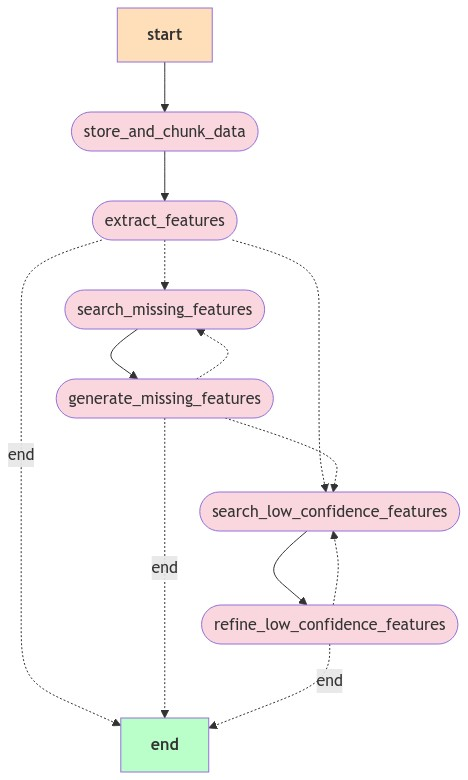

INFO:feature_extraction.agentic_feature_extractor:Starting feature extraction workflow.
INFO:feature_extraction.agentic_feature_extractor:Storing and chunking raw data.
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"


Input data: TemplateVECUserManual User Manual PCE LGA Intel Xeon Core iiCeleronPentium PICMG Halfsize System Host Board VGA DVID DDR SATA USB Dual GbE Copyright The documentation software included product copyrighted Advantech Co Ltd All rights reserved Advantech Co Ltd reserves right make improvements products described manual time without notice No part manual may reproduced copied translated transmitted form means without prior written permission Advantech Co Ltd Information provided manual intended accurate reliable How ever Advantech Co Ltd assumes responsibility use infringe ments rights third parties may result use Acknowledgements AMIBIOS trademark American Megatrends Inc Intel Coreiii Pentium Xeon trademarks Intel Corporation Nuvoton trademark Nuvoton Technology Corp All product names trademarks properties respective owners Product Warranty years Advantech warrants original purchaser products free defects materials workmanship two years date pur chase This warranty apply produ

INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: cf7d4c7d-06e0-4d01-9d36-a131a8f43815
INFO:services.weaviate_service:Storing 32 chunks for product TEST279
INFO:weaviate_interface.weaviate_client:Inserting 32 objects into collection ProductDataChunk
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 60b005a4-5029-4159-aefb-7ea1a603f1c6
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 3365d71e-164a-412d-8742-b6854fab8001
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: dca0ab6f-2611-49db-a389-957fb0b37ca1
INFO:ht

{
  "extracted_data": {
    "name": "ADVENTECH PCE",
    "manufacturer": "ADVENTECH",
    "form_factor": "HALF-SIZE SYSTEM HOST BOARD",
    "evaluation_or_commercialization": false,
    "processor_architecture": "INTEL XEON, CORE III, PENTIUM, CELERON",
    "processor_core_count": "QUAD/DUAL-CORE",
    "processor_manufacturer": "INTEL",
    "processor_tdp": "Not Available",
    "memory": "UP TO 8GB DDR3 SDRAM",
    "onboard_storage": "SATA GEN 3",
    "input_voltage": "V, V, V, VSB",
    "io_count": "USB X 4, SATA X 2, LAN X 2, COM X 2, VGA X 1, LPT X 1, KBMS X 1",
    "wireless": "Not Available",
    "operating_system_bsp": "WINDOWS XP",
    "operating_temperature_max": "Not Available",
    "operating_temperature_min": "Not Available",
    "certifications": "FCC CLASS B",
    "price": "Not Available",
    "stock_availability": "Not Available",
    "lead_time": "Not Available",
    "short_summary": "The Advantech PCE is a half-size system host board designed for industrial applications

In [4]:
async def test_initial_extraction(extractor, data):
    print(f"Input data: {data}")
    result = await extractor.extract_data(data, "TEST279")
    print(json.dumps(result, indent=2))


feature_extraction = AgenticFeatureExtractor(
    services, prompt_manager, config=ConfigSchema(max_missing_feature_attempts=0, max_low_confidence_attempts=0)
)

visualize_workflow(feature_extraction)
await test_initial_extraction(feature_extraction, raw_data["raw_data"].iloc[0])

### 3. Missing Feature Search and Generation Test

INFO:feature_extraction.agentic_feature_extractor:Required features: {'name': 'The official name of the product.', 'manufacturer': 'The company that produces the product.', 'form_factor': 'The physical dimensions or standard of the product.', 'evaluation_or_commercialization': 'Indicates if the product is for evaluation or commercial use (True for evaluation, False for commercial).', 'processor_architecture': 'The architecture of the processor (e.g., ARM, x86).', 'processor_core_count': 'The number of cores in the processor.', 'processor_manufacturer': 'The company that manufactures the processor.', 'processor_tdp': 'The Thermal Design Power of the processor.', 'memory': 'The size and type of RAM in the product.', 'onboard_storage': 'The amount and type of built-in storage.', 'input_voltage': 'The required input voltage for operation.', 'io_count': 'The count and types of Input/Output interfaces.', 'wireless': 'Wireless capabilities (e.g., Wi-Fi, Bluetooth).', 'operating_system_bsp': '

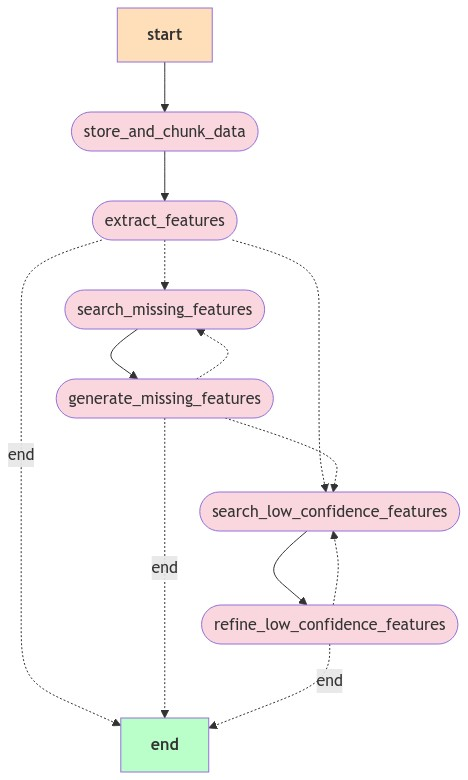

INFO:feature_extraction.agentic_feature_extractor:Starting feature extraction workflow.
INFO:feature_extraction.agentic_feature_extractor:Storing and chunking raw data.
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"


Input data: TemplateVECUserManual User Manual PCE LGA Intel Xeon Core iiCeleronPentium PICMG Halfsize System Host Board VGA DVID DDR SATA USB Dual GbE Copyright The documentation software included product copyrighted Advantech Co Ltd All rights reserved Advantech Co Ltd reserves right make improvements products described manual time without notice No part manual may reproduced copied translated transmitted form means without prior written permission Advantech Co Ltd Information provided manual intended accurate reliable How ever Advantech Co Ltd assumes responsibility use infringe ments rights third parties may result use Acknowledgements AMIBIOS trademark American Megatrends Inc Intel Coreiii Pentium Xeon trademarks Intel Corporation Nuvoton trademark Nuvoton Technology Corp All product names trademarks properties respective owners Product Warranty years Advantech warrants original purchaser products free defects materials workmanship two years date pur chase This warranty apply produ

INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 70ab3e58-e0ab-447c-b1e4-d084bc7b8cbd
INFO:services.weaviate_service:Storing 32 chunks for product TEST279
INFO:weaviate_interface.weaviate_client:Inserting 32 objects into collection ProductDataChunk
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 70125dd4-20d4-41b6-97a4-be796e7e7fa1
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 4cb88a59-bbe1-4a77-9da6-f0e9701cb8da
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weavia

{
  "extracted_data": {
    "name": "PCE LGA INTEL XEON CORE IICELERONPENTIUM PICMG HALFSIZE SYSTEM HOST BOARD",
    "manufacturer": "ADVANTECH",
    "form_factor": "HALFSIZE SYSTEM HOST BOARD",
    "evaluation_or_commercialization": "Not Available",
    "processor_architecture": "LGA",
    "processor_core_count": "Not Available",
    "processor_manufacturer": "INTEL",
    "processor_tdp": "Not Available",
    "memory": "UP TO GB DDR MHZ SDRAM",
    "onboard_storage": "SUPPORTS TWO SATA PORTS",
    "input_voltage": "Not Available",
    "io_count": "ONE PCIE X, TWO PCIE X, TWO RS SERIAL PORTS, ONE PS KEYBOARD MOUSE CONNECTOR, X USB MBPS, X USB GBPS",
    "wireless": "Not Available",
    "operating_system_bsp": "Not Available",
    "operating_temperature_max": "Not Available",
    "operating_temperature_min": "Not Available",
    "certifications": "FCC CLASS B",
    "price": "Not Available",
    "stock_availability": "Not Available",
    "lead_time": "Not Available",
    "short_summary":

In [5]:
async def test_missing_feature_handling(extractor, data):
    print(f"Input data: {data}")
    result = await extractor.extract_data(data, "TEST279")
    print(json.dumps(result, indent=2))

feature_extraction = AgenticFeatureExtractor(
    services, prompt_manager, config=ConfigSchema(max_missing_feature_attempts=2, max_low_confidence_attempts=0)
)

visualize_workflow(feature_extraction)
await test_missing_feature_handling(feature_extraction, raw_data["raw_data"].iloc[0])

### 5. Low Confidence Feature Refinement Test


INFO:feature_extraction.agentic_feature_extractor:Required features: {'name': 'The official name of the product, in clear, capital case, singular, without special characters. (Only the official name, dont include Code Name, or any other variant)', 'manufacturer': 'The company or brand responsible for manufacturing the product, in clear, capital case, singular, without special characters.', 'is_prototype': 'A boolean value (True/False) indicating whether the product is a prototype or a production model.', 'form_factor': "The physical dimensions, shape, or standard that defines the product's size (e.g., '63.5 x 38.1 x 10.2 mm', '3U VPX').", 'processor': {'manufacturer': "The company that produces the processor (e.g., 'Intel', 'AMD', 'ARM').", 'model': "The specific model of the processor (e.g., 'i7-1185GRE', 'Cortex-A8').", 'speed': "The base clock speed of the processor in GHz (e.g., '1.8 GHz').", 'max_speed': 'The maximum turbo or boost clock speed of the processor in GHz, if applicabl

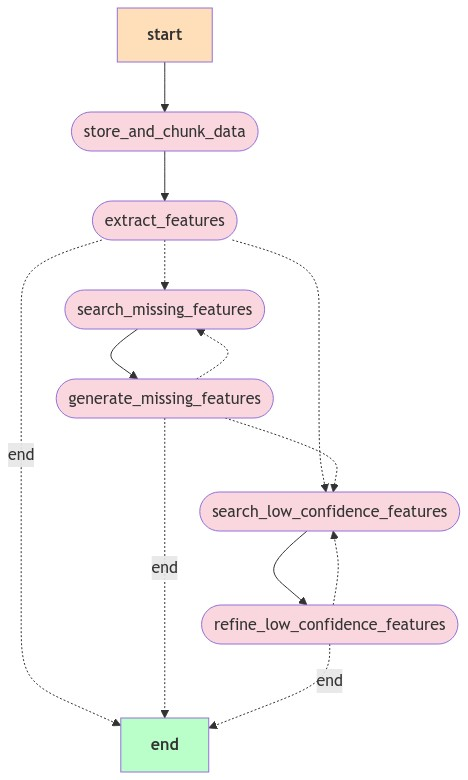

INFO:feature_extraction.agentic_feature_extractor:Starting feature extraction workflow.
INFO:feature_extraction.agentic_feature_extractor:Storing and chunking raw data.
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"


Input data: TemplateVECUserManual User Manual PCE LGA Intel Xeon Core iiCeleronPentium PICMG Halfsize System Host Board VGA DVID DDR SATA USB Dual GbE Copyright The documentation software included product copyrighted Advantech Co Ltd All rights reserved Advantech Co Ltd reserves right make improvements products described manual time without notice No part manual may reproduced copied translated transmitted form means without prior written permission Advantech Co Ltd Information provided manual intended accurate reliable How ever Advantech Co Ltd assumes responsibility use infringe ments rights third parties may result use Acknowledgements AMIBIOS trademark American Megatrends Inc Intel Coreiii Pentium Xeon trademarks Intel Corporation Nuvoton trademark Nuvoton Technology Corp All product names trademarks properties respective owners Product Warranty years Advantech warrants original purchaser products free defects materials workmanship two years date pur chase This warranty apply produ

INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 69e971cc-f8a9-412b-8528-e045c8964eab
INFO:services.weaviate_service:Storing 32 chunks for product TEST279
INFO:weaviate_interface.weaviate_client:Inserting 32 objects into collection ProductDataChunk
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: c68ac237-e3f3-4095-ac7f-b9e565d1ff3d
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: ed1e8536-1466-4e15-bc4e-54e4bf33315b
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: f0abe76e-d472-4af9-b4aa-d4f23f14e670
INFO:ht

{
  "extracted_data": {
    "name": "HEALTHCARE INFORMATION TERMINAL",
    "manufacturer": "ADVANTECH",
    "is_prototype": false,
    "form_factor": "Not Available",
    "processor": {
      "manufacturer": "INTEL",
      "model": "APOLLO LAKE N4200",
      "speed": "2.5 GHz",
      "max_speed": "Not Available",
      "core_count": "Not Available",
      "thread_count": "Not Available",
      "architecture": "Not Available",
      "features": "Not Available",
      "tdp": "Not Available"
    },
    "memory": {
      "ram_type": "DDR3L",
      "ram_speed": "Not Available",
      "ram_capacity": "UP TO 8 GB",
      "ram_configuration": "Not Available"
    },
    "storage": {
      "storage_type": "M.2 2242",
      "storage_capacity": "UP TO 128 GB"
    },
    "gpu_model": "Not Available",
    "interfaces": {
      "display_outputs": "Not Available",
      "ethernet_ports": [
        "1x 10/100/1000 Mbps"
      ],
      "usb_ports": [
        "2x USB 3.0",
        "2x USB 2.0"
      ],
 

In [4]:
async def test_low_confidence_refinement(extractor, data):
    print(f"Input data: {data}")
    result = await extractor.extract_data(data, "TEST279")
    print(json.dumps(result, indent=2))


feature_extraction = AgenticFeatureExtractor(
    services, prompt_manager, config=ConfigSchema(max_missing_feature_attempts=0, max_low_confidence_attempts=1)
)

visualize_workflow(feature_extraction)
await test_low_confidence_refinement(feature_extraction, raw_data["raw_data"].iloc[0])
